### 1. Importação de Bibliotecas

In [1]:
#Importação de bibliotecas

#Bibliotecas para dados e gráficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

#Biblioteca para implementar barra de progresso
import progressbar

#Bibliotecas para exportar e importar arquivos
from joblib import dump, load

#Biblioteca utilitário de GPU
from numba import cuda

from sklearn.model_selection import train_test_split

In [2]:
#checa a GPU e limpa ela
device = cuda.get_current_device()
print(device)
device.reset()

!nvidia-smi

<CUDA device 0 'b'NVIDIA GeForce GTX 1050 Ti''>
Tue Oct  3 17:08:44 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.42                 Driver Version: 537.42       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti   WDDM  | 00000000:02:00.0  On |                  N/A |
|  0%   40C    P0              N/A /  72W |    540MiB /  4096MiB |      4%      Default |
|                                         |                      |                  N/A |
+-------------------

#### 1.1 Caminho do *dataset*

In [3]:
#path to the dataset archive
path = '../'

### 2. Aquisição e preparação do *dataset*

In [4]:
file_name = 'dataset_csv/data_margem_05.csv'
x_column  = 'load_mwh'
y_column  = 'is_outlier'

data = pd.read_csv(path + file_name, header=0)
data

,date,int_hour,subsistema,load_mwh,is_outlier
0,2020-01-01,0,Sudeste/Centro-Oeste,33108,False
1,2020-01-01,1,Sudeste/Centro-Oeste,33368,False
2,2020-01-01,2,Sudeste/Centro-Oeste,33040,False
3,2020-01-01,3,Sudeste/Centro-Oeste,32399,False
4,2020-01-01,4,Sudeste/Centro-Oeste,31776,False
...,...,...,...,...,...
26299,2022-12-31,19,Sudeste/Centro-Oeste,44647,False
26300,2022-12-31,20,Sudeste/Centro-Oeste,43516,False
26301,2022-12-31,21,Sudeste/Centro-Oeste,39411,False
26302,2022-12-31,22,Sudeste/Centro-Oeste,35797,False


In [5]:
x_serie = data[x_column].values.reshape(-1, 1)
y_serie = data[y_column].values.reshape(-1, 1).astype(np.int8)

### 4. Análise dos Dados

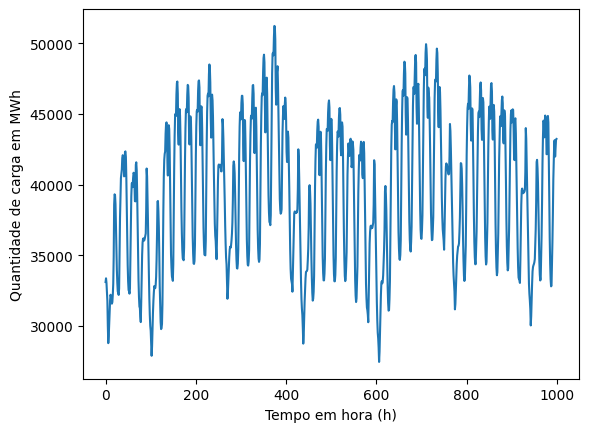

In [6]:
plt.plot(x_serie[:1000])
plt.xlabel('Tempo em hora (h)')
plt.ylabel('Quantidade de carga em MWh')
plt.show()

##### 4.1 Verificando dados faltantes

In [7]:
missing_data_counts = data.isnull().sum()
print('Total de dados faltantes por atributo:')
missing_data_counts

Total de dados faltantes por atributo:


date          0
int_hour      0
subsistema    0
load_mwh      0
is_outlier    0
dtype: int64

##### 4.2 Sumarização estatística

In [8]:
def summarize_data(data):
    statistics = []

    maximum_value = round(np.max(data), 2)
    minimum_value = round(np.min(data), 2)
    mean_value = round(np.mean(data), 2)
    median_value = round(np.median(data), 2)
    std_value = round(np.std(data), 2)
    statistics.append([maximum_value, minimum_value, mean_value, median_value, std_value])

    table_headers = ['Máximo', 'Mínimo', 'Média', 'Mediana', 'Desvio Padrão']
    table = tabulate(statistics, table_headers, tablefmt="pipe")
    print(table)

In [9]:
summarize_data(x_serie)

|   Máximo |   Mínimo |   Média |   Mediana |   Desvio Padrão |
|---------:|---------:|--------:|----------:|----------------:|
|    52571 |    21658 | 38389.2 |     38399 |         5708.31 |


##### 4.3 Gráficos

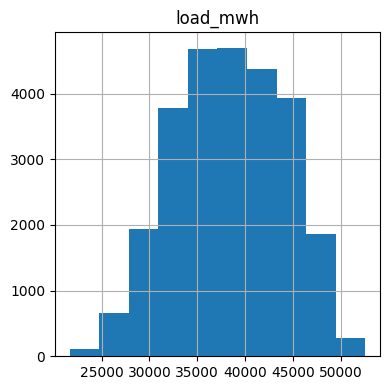

In [10]:
data.hist(column=x_column, figsize=(4, 4))
plt.tight_layout()
plt.show()

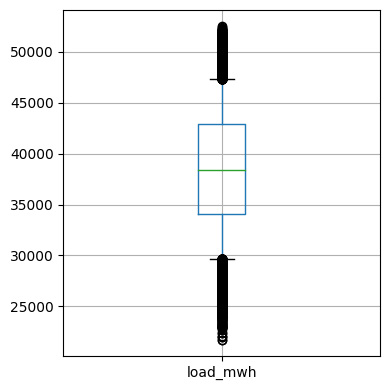

In [11]:
data.boxplot(column=x_column, whis=0.5, figsize=(4, 4))
plt.tight_layout()
plt.show()

In [12]:
outliers_count = len(data.loc[data[y_column] == True])
print('Quantidade de outliers: ', outliers_count)

Quantidade de outliers:  3032


In [13]:
print('Porcentagem de outliers em relação a amostra: {:.2f}%'.format((outliers_count / len(data)) * 100))

Porcentagem de outliers em relação a amostra: 11.53%


#### 4.3 Divisão do conjunto

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_serie[0:26304], y_serie[0:26304], test_size=0.333, shuffle=False)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(17544, 1)
(17544, 1)
(8760, 1)
(8760, 1)


#### 4.3 Aplicando normalização e escala [0, 1]

In [15]:
def min_max_normalization(data, min_data, max_data):
    min_val = min_data
    max_val = max_data
    normalized_data = []
    
    for value in data:
        normalized_value = ((value - min_val) / (max_val - min_val)) 
        normalized_data.append(normalized_value)
    
    return normalized_data

In [16]:
x_train_esc = min_max_normalization(x_train, min_data=19000, max_data=55000)
x_test_esc = min_max_normalization(x_test, min_data=19000, max_data=55000)

x_train_esc = np.vstack(x_train_esc)
x_test_esc = np.vstack(x_test_esc)

### 5. Exportando ou carregando o dataset

In [17]:
#Parameters
export_frames = True

#Frame files
x_frame_file = 'x_frames_treino_05.joblib'
x2_frame_file = 'x_frames_teste_05.joblib'


y_frame_file = 'y_frames_treino_05.joblib'
y2_frame_file = 'y_frames_teste_05.joblib'



In [18]:
if export_frames == True:
    #Create a progress bar illustrating the data export process
    progress_bar = progressbar.ProgressBar(maxval=len(x_serie), widgets=[progressbar.Bar("=", "[", "]"), " ", progressbar.Percentage()])
    progress_bar.start()
    
    #Save the data in the given path
    dump(x_train_esc, path + 'dataset/' + x_frame_file)
    dump(y_train, path + 'dataset/' + y_frame_file)

    dump(x_test_esc, path + 'dataset/' + x2_frame_file)
    dump(y_test, path + 'dataset/' + y2_frame_file)

    progress_bar.finish()
else:
    x_train = load(path + 'dataset/' + x_frame_file)
    y_train = load(path + 'dataset/' + y_frame_file)

    x_test = load(path + 'dataset/' + x2_frame_file)
    y_test = load(path + 'dataset/' + y2_frame_file)


[========================================================================] 100%
